# Specification MDPs#

Now we consider the planning domains obtained through the cross product of the specification FSM and the control MDP. This is a regular MDP with the actions and transitions governed by the control MDP, but the rewards are governed by the specification FSM states. In this you can use your favorite algorithm to train the policy (usually off-policy model-free versions as we do not assume that a complete enumeration of the control MDP states is available)

In [18]:
from SpecificationMDP import *
import matplotlib 
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [32,18]

Lets start by defining our ingredient MDPs. We are doing this for the synthetic domain

In [22]:
    PathToDataFile = ''
    SampleSignal = Constants.ImportSampleData(PathToDataFile)
    TraceSlice = GetTraceSlice(SampleSignal,0)
    Formulas, Prob = Constants.ImportCandidateFormulas()
    idx = np.argsort(Prob)[::-1]
    Formulas_synth = np.array(Formulas)[idx]
    Probs = np.array(Prob)[idx]
    ProgressedFormulas = np.array([ProgressSingleTimeStep(formula, TraceSlice) for formula in Formulas_synth])
    
    specification_fsm = SpecificationFSM(ProgressedFormulas, Probs, reward_type='chance_constrained', risk_level=0.25)
    control_mdp = SyntheticMDP(5, 4)

Now lets use the Specification MDP class to define our full fledged MDP

In [23]:
MDP = SpecificationMDP(specification_fsm, control_mdp)

We can use an MDP like interface to interact with this

In [24]:
print(MDP.state)


(('["and", ["G", ["and", ["not", ["T0"]], ["not", ["T1"]], ["not", ["T2"]], ["not", ["T3"]], ["not", ["T4"]]]], ["F", ["W0"]], ["F", ["W1"]], ["F", ["W2"]], ["F", ["W3"]], ["U", ["not", ["W1"]], ["W0"]], ["U", ["not", ["W2"]], ["W0"]], ["U", ["not", ["W2"]], ["W1"]]]', '["and", ["G", ["and", ["not", ["T0"]], ["not", ["T1"]], ["not", ["T2"]], ["not", ["T3"]], ["not", ["T4"]]]], ["F", ["W0"]], ["F", ["W1"]], ["F", ["W2"]], ["F", ["W3"]], ["U", ["not", ["W1"]], ["W0"]], ["U", ["not", ["W3"]], ["W0"]], ["U", ["not", ["W2"]], ["W0"]], ["U", ["not", ["W3"]], ["W1"]], ["U", ["not", ["W2"]], ["W1"]]]', '["and", ["G", ["and", ["not", ["T0"]], ["not", ["T1"]], ["not", ["T2"]], ["not", ["T3"]], ["not", ["T4"]]]], ["F", ["W0"]], ["F", ["W1"]], ["F", ["W2"]], ["F", ["W3"]], ["U", ["not", ["W1"]], ["W0"]], ["U", ["not", ["W2"]], ["W0"]], ["U", ["not", ["W3"]], ["W0"]], ["U", ["not", ["W2"]], ["W1"]], ["U", ["not", ["W3"]], ["W1"]]]', '["and", ["G", ["and", ["not", ["T0"]], ["not", ["T1"]], ["not", [

Note that the state is a pretty large and unwieldy descriptor that works very well with the hashmaps we use to represent transitions and policies, so we define the `easy_state` property that maps each state to a unique id

In [25]:
print(MDP.easy_state)


(0, (False, False, False, False, False, False, False, False, False))


In [26]:
print(MDP.get_actions())

['T0', 'T1', 'T2', 'T3', 'T4', 'W0', 'W1', 'W2', 'W3']


In [27]:
state, reward = MDP.transition(MDP.state, 'T1')
print(MDP.easy_state, reward)

(15, (False, True, False, False, False, False, False, False, False)) 0


To randomly explore in this domain by randomly sampling the actions we would like to take, we use `RandomExploration` function. Here we command the agent to randomly explore for 5000 episodes and not perform more than 10000 actions

In [28]:
G, episode_records, episodes, actions = RandomExploration(MDP, episode_limit = 5000, action_limit=10000, verbose=False)

Next, we collect some summary statistics from the training protocol

In [29]:
node_dict = dict(G.nodes(data='name'))
edge_dict = dict([((u,v),c) for (u,v,c) in G.edges.data('action')])
easy_episodic_record = []
    
for record in episode_records:
    new_record = []
    for entry in record:
        new_record.append((node_dict[entry[0]], entry[1], node_dict[entry[2]], entry[3]))
    easy_episodic_record.append(new_record)

terminal_id = [records[-1][2] for records in easy_episodic_record]
id2nodes = dict([(v,k) for (k,v) in node_dict.items()])
final_rewards = [record[-1][3] for record in easy_episodic_record]

terminal_states = [id2nodes[idx] for idx in terminal_id]

Now lets plot the states that have been visited by the planner over the course of its exploration

In [30]:
pos = nx.drawing.nx_agraph.graphviz_layout(G, prog='dot')

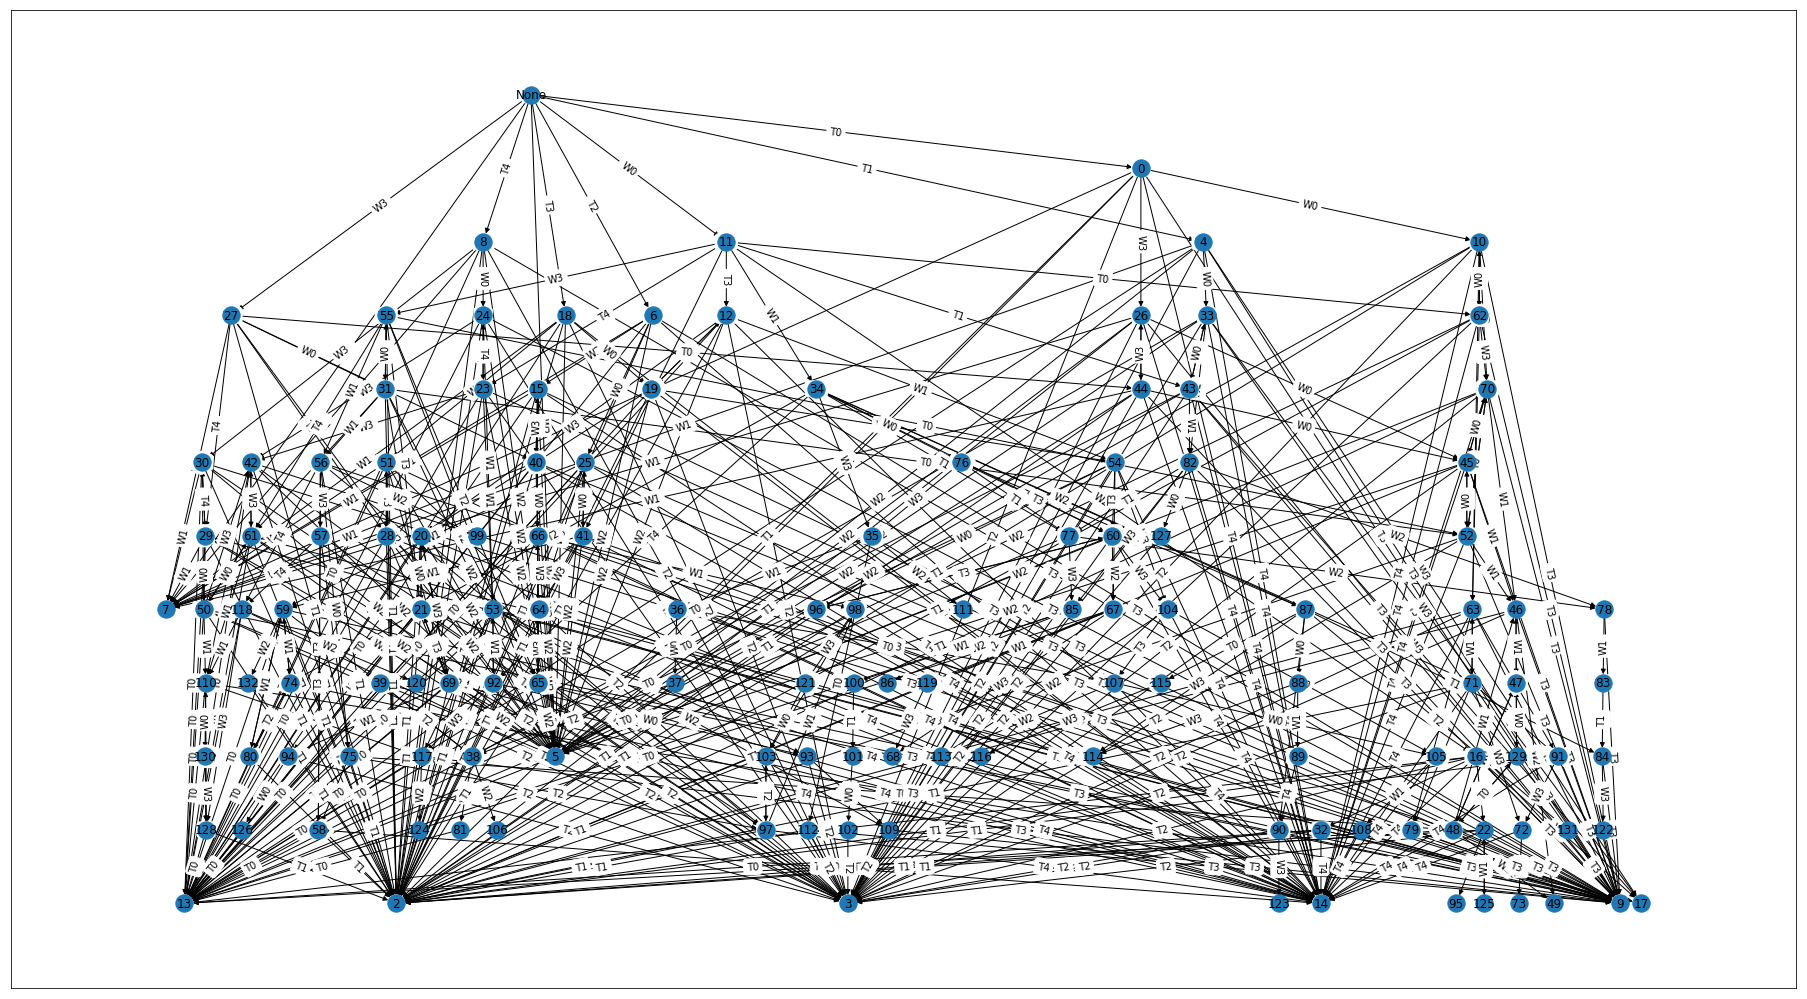

In [31]:
nx.draw_networkx(G, pos, with_labels=False)
_ = nx.draw_networkx_labels(G, pos, node_dict)
_ = nx.draw_networkx_edge_labels(G, pos, edge_dict)

We can also color the nodes by the final reward obtained in the terminal states

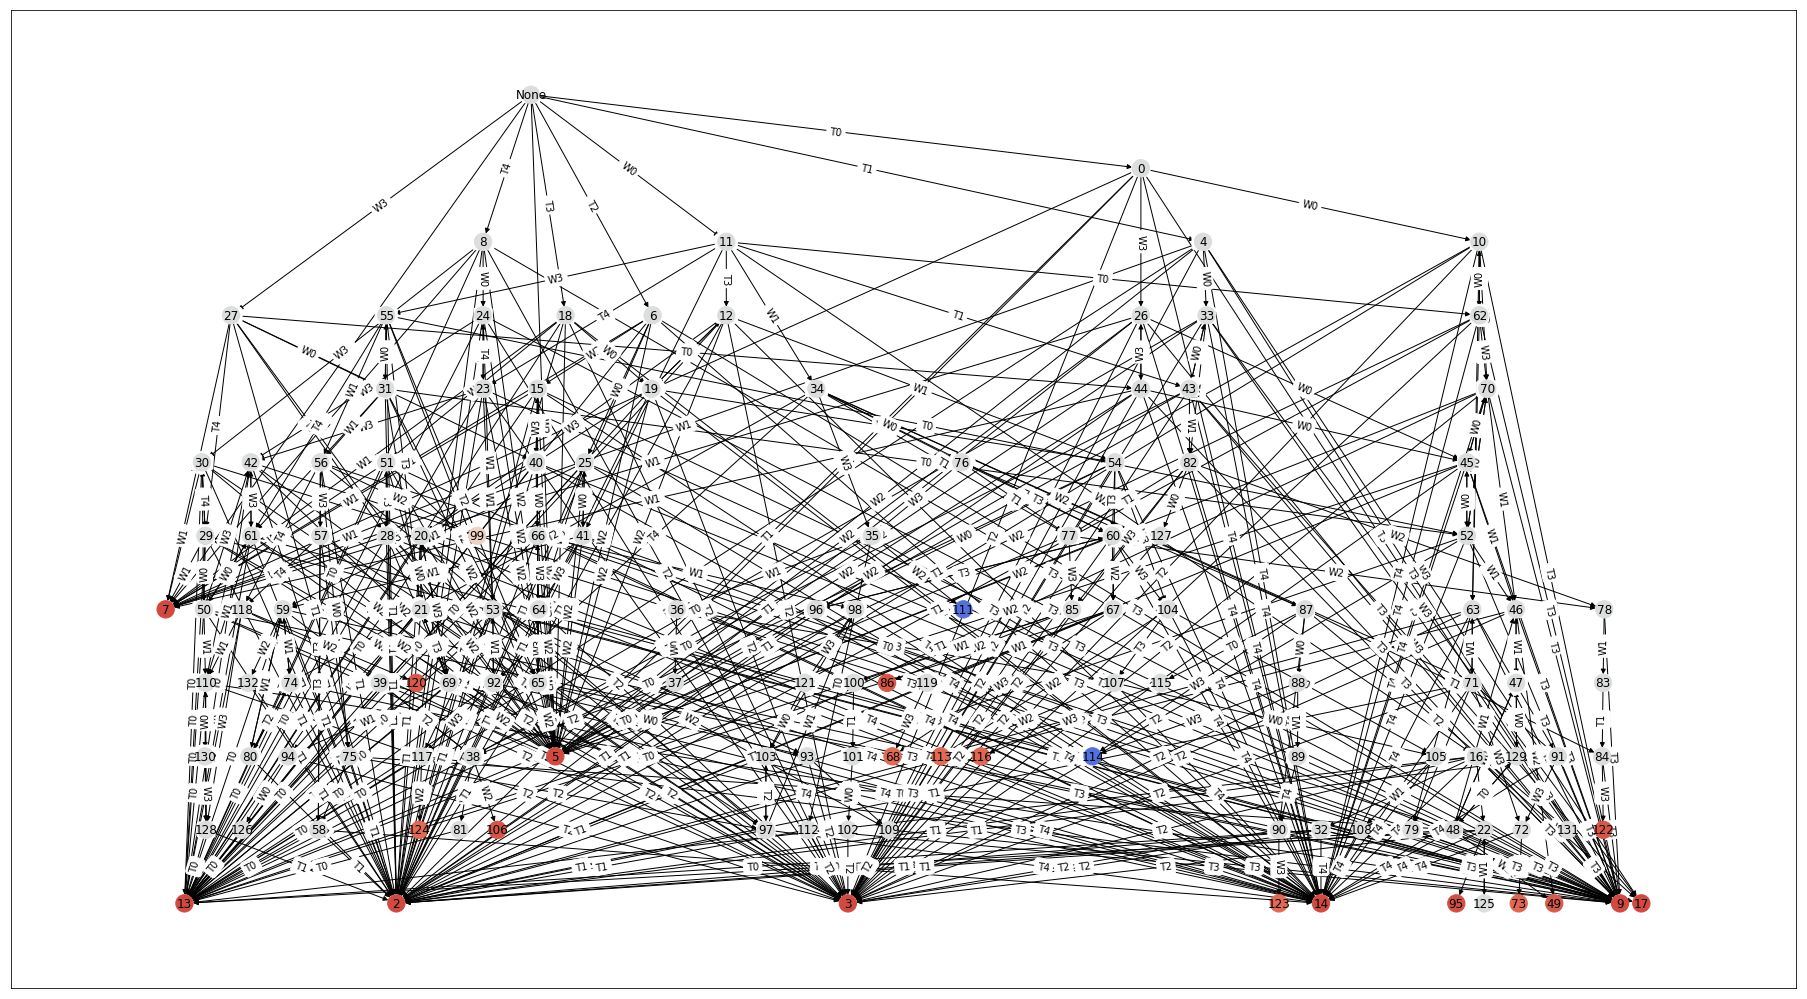

In [32]:
colors = [MDP.reward_function(node) for node in G.nodes()]
    
plt.figure()
nx.draw_networkx(G, pos, with_labels=False, node_color=colors, cmap='coolwarm_r', vmin=-1.2, vmax=1.2)
_ = nx.draw_networkx_labels(G, pos, node_dict)
_ = nx.draw_networkx_edge_labels(G, pos, edge_dict)